In [15]:
from typing import List
from itertools import combinations
import numpy as np
import dask.dataframe as dd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [16]:
import matplotlib.pyplot as plt

In [17]:
dir = "./data/random/fixed/"
real = dd.read_parquet(dir+"main.parquet", columns=["spec","variant","real.tests", "real.downs", "size", "clocks"])
squished = dd.read_parquet(dir+"squished.parquet", columns=["spec","variant","approx.tests", "approx.downs", "limit.tests", "limit.downs"])
opti = dd.read_parquet(dir+"opti/init_weights.min_front.parquet", index=["spec"],columns=["variant","comb", "real.tests", "real.downs"])
squished = squished.groupby(["spec", "variant"]).max()

real_max = real.groupby(["spec", "variant"]).max()

In [18]:
comparison_squished = real_max.join(squished, on=["spec", "variant"]).compute()

In [41]:
comparison_squished["limit.diff"] = ((comparison_squished["limit.tests"]-comparison_squished["real.tests"])/comparison_squished["real.tests"])*100

In [48]:
comparison_squished["approx.diff"] = (comparison_squished["approx.tests"]/comparison_squished["real.tests"]-1)*100

### Difference percentage limit vs real max

In [49]:
approximation_comp = comparison_squished[["limit.diff", "approx.diff", "size"]].groupby(["size"]).agg(["max", "min", "mean", "std"])

In [97]:
len(opti.groupby("spec").count().index)

1660

<AxesSubplot:xlabel='size'>

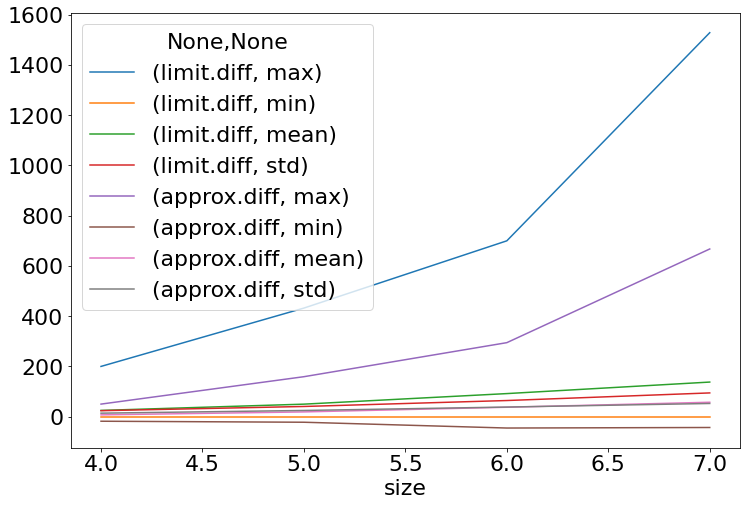

In [52]:
approximation_comp.plot(figsize=(12,8))

<Figure size 1008x576 with 0 Axes>

Text(0.5, 0, 'Size')

Text(0, 0.5, 'Error (%)')

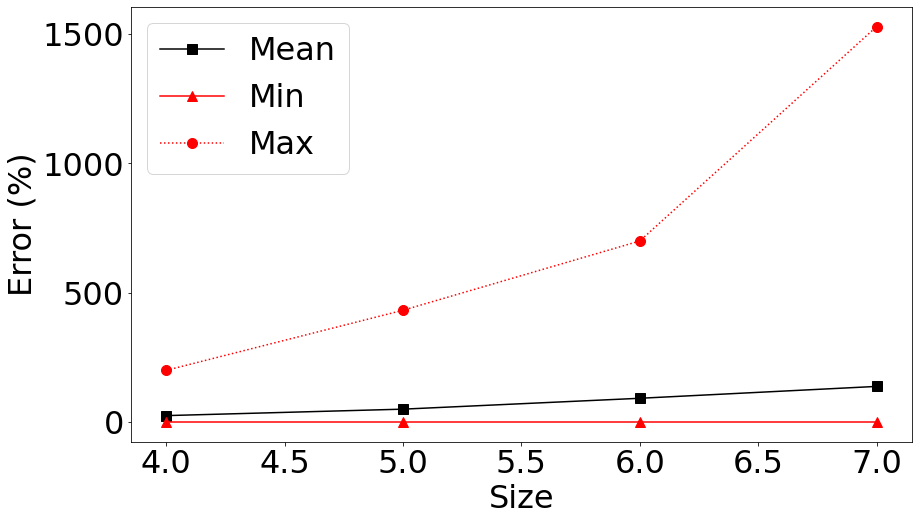

In [112]:
ma = approximation_comp[("limit.diff", "mean")]
mstd = approximation_comp[("limit.diff", "std")]
plt.figure(figsize=(14,8))
plt.plot(approximation_comp.index, ma, "k-s", label="Mean", markersize=10,)
plt.plot(approximation_comp.index, approximation_comp[("limit.diff", "min")], "r-^", label="Min", markersize=10,)
plt.plot(approximation_comp.index, approximation_comp[("limit.diff", "max")], "r:o", label="Max", markersize=10,)
#plt.fill_between(mstd.index, ma - 2 * mstd, ma + 2 * mstd, color="b", alpha=0.2, label="Std")
plt.xlabel("Size")
plt.ylabel("Error (%)")
font = {'family' : 'normal',
        'size'   : 32}

plt.rc('font', **font)
plt.legend()
plt.savefig("limit_diff_approx.pdf")

<Figure size 864x576 with 0 Axes>

Text(0.5, 0, 'Size')

Text(0, 0.5, 'Error (%)')

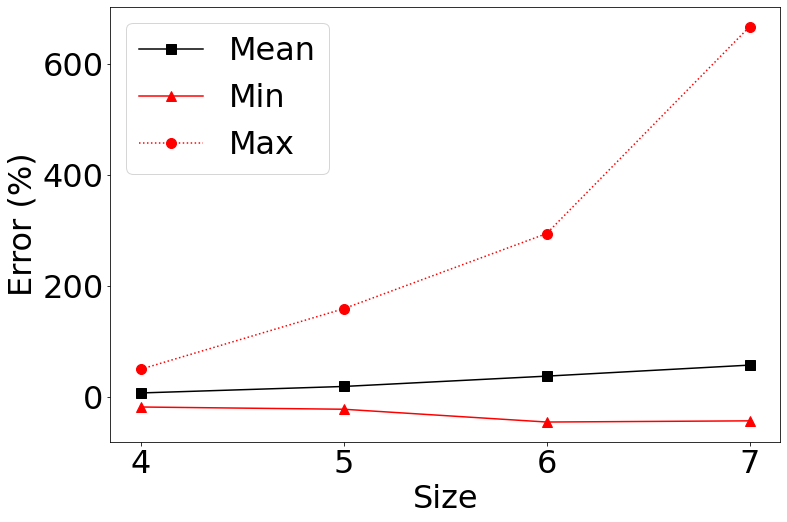

In [113]:
ma = approximation_comp[("approx.diff", "mean")]
mstd = approximation_comp[("approx.diff", "std")]
plt.figure(figsize=(12,8))
plt.plot(approximation_comp.index, ma, "k-s", label="Mean", markersize=10,)
plt.plot(approximation_comp.index, approximation_comp[("approx.diff", "min")], "r-^", label="Min", markersize=10,)
plt.plot(approximation_comp.index, approximation_comp[("approx.diff", "max")], "r:o", label="Max", markersize=10,)
#plt.fill_between(mstd.index, ma - 2 * mstd, ma + 2 * mstd, color="b", alpha=0.2, label="Std")
plt.xlabel("Size")
plt.ylabel("Error (%)")
font = {'family' : 'normal',
        'size'   : 32}

plt.rc('font', **font)
plt.legend()
plt.savefig("approx_diff_approx.pdf")

### Specifications that fails to be approximated correctly

In [56]:
comparison_squished[comparison_squished["approx.tests"] < comparison_squished["real.tests"]]

real.tests  real.downs  size  clocks  \
spec                 variant                                         
57036280707606070    480             420         166     7       8   
                     481             452         182     7       8   
                     482             414         164     7       8   
                     484             464         190     7       8   
                     486             414         162     7       8   
...                                  ...         ...   ...     ...   
18415264097865192794 118             160          50     5       6   
18432962492680829874 0                74          30     4       5   
                     2                74          30     4       5   
                     6                73          29     4       5   
                     12               73          29     4       5   

                              approx.tests  approx.downs  limit.tests  \
spec                 variant                                            
57036280707606070    480               402           158          684   
                     481               432           173          636   
                     482               402           158          684   
                     484               452           183          612   
                     486               392           153          696   
...                                    ...           ...          ...   
18415264097865192794 118               152            54          220   
18432962492680829874 0                  70            28          104   
                     2                  70            28          104   
                     6                  69            27           81   
                     12                 69            27           81   

                              limit.downs  limit.diff  approx.diff  
spec                 variant                                        
57036280707606070    480              285   62.857143    -4.285714  
                     481              285   40.707965    -4.424779  
                     482              285   65.217391    -2.898551  
                     484              285   31.896552    -2.586207  
                     486              285   68.115942    -5.314010  
...                                   ...         ...          ...  
18415264097865192794 118               92   37.500000    -5.000000  
18432962492680829874 0                 44   40.540541    -5.405405  
                     2                 44   40.540541    -5.405405  
                     6                 33   10.958904    -5.479452  
                     12                33   10.958904    -5.479452  

[84544 rows x 10 columns]

### Raw limit vs real max percentage

<AxesSubplot:xlabel='spec,variant'>

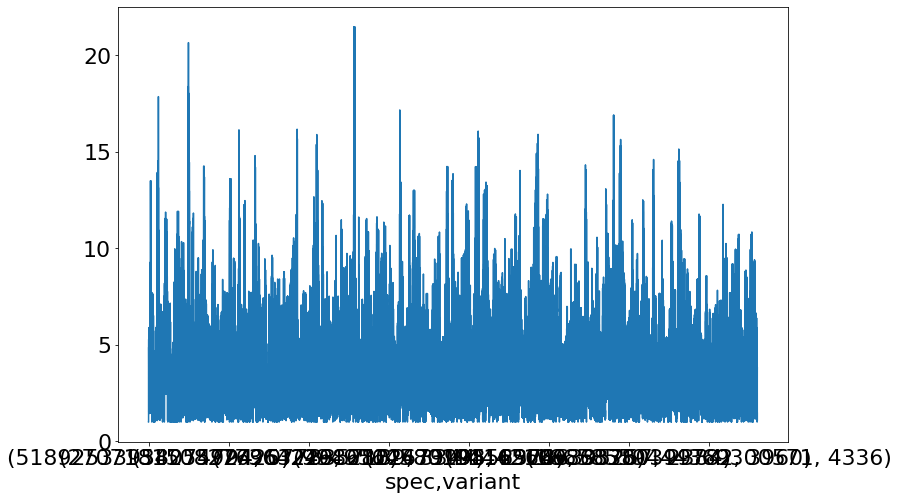

In [57]:
(comparison_squished["limit.downs"]/comparison_squished["real.downs"]).plot(figsize=(12,8))

In [58]:
opti_max = opti.groupby("spec").max()
real_statistics = real_max.groupby("spec").aggregate(["min", "max", "mean"])
compare = real_statistics.join(opti_max)
comparison_opti = compare.compute()

/home/ptokarie/code/ccsl-rs/plotter/venv/lib/python3.9/site-packages/dask/dataframe/multi.py:393: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  meta = left._meta_nonempty.merge(right._meta_nonempty, **kwargs)
/home/ptokarie/code/ccsl-rs/plotter/venv/lib/python3.9/site-packages/dask/dataframe/multi.py:275: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  out = lhs.merge(rhs, *args, **kwargs)


### Specification complexity range evolution (natural order)

/home/ptokarie/code/ccsl-rs/plotter/venv/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


<AxesSubplot:xlabel='spec'>

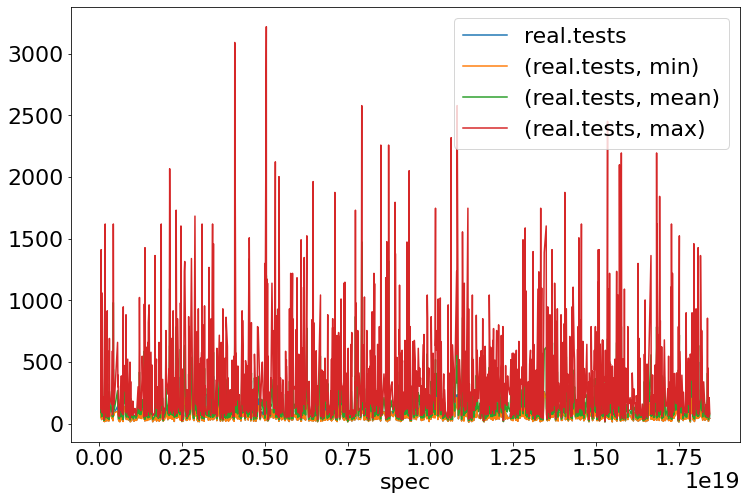

In [59]:
comparison_opti[["real.tests", ("real.tests", "min"), ("real.tests", "mean"), ("real.tests", "max")]].plot(figsize=(12, 8))

### Specification complexity range evolution (size)

<AxesSubplot:xlabel='size', ylabel='diff'>

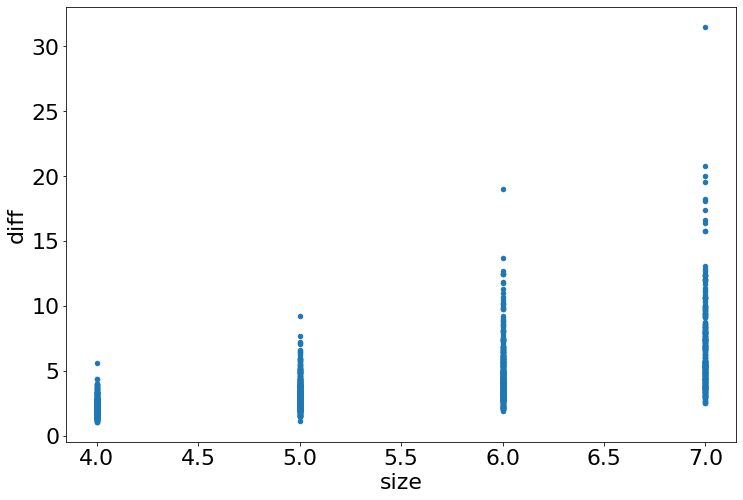

In [60]:
comparison_opti2 = comparison_opti.sort_values(("clocks", "max"))
comparison_opti2["diff"] = comparison_opti2[("real.tests", "max")]/comparison_opti2[("real.tests", "min")]
comparison_opti2["size"] = comparison_opti2[("size","max")]
comparison_opti2["clocks"] = comparison_opti2[("clocks","max")]
comparison_opti2.sort_values("size").plot.scatter(x="size", y="diff",figsize=(12, 8))

<AxesSubplot:xlabel='size'>

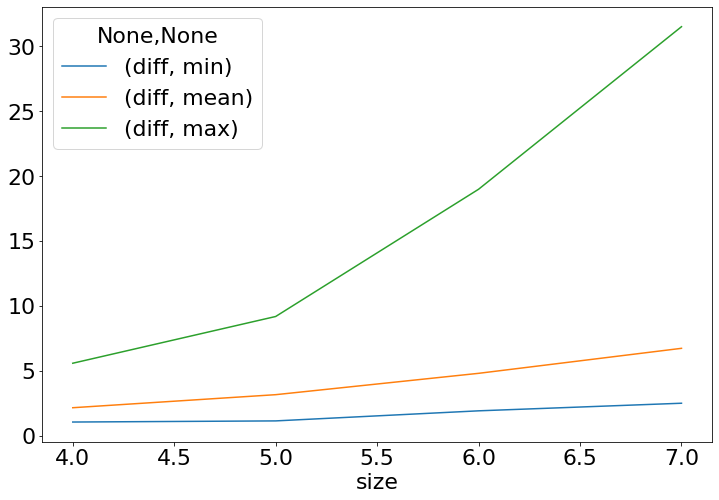

In [61]:
comparison_opti2[["size", "diff"]].groupby(["size"]).aggregate(["min", "mean", "max"]).plot(figsize=(12, 8))

<AxesSubplot:xlabel='clocks', ylabel='diff'>

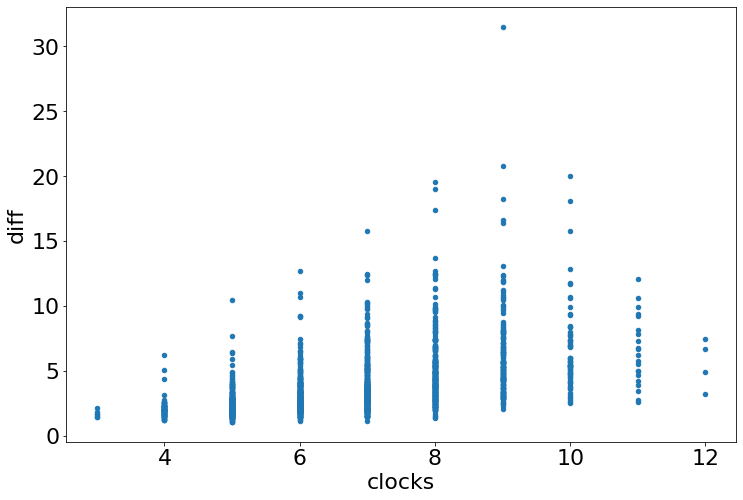

In [62]:
comparison_opti2.sort_values("clocks").plot.scatter(x="clocks", y="diff",figsize=(12, 8))

### All failed to optimize specifications

In [63]:
comparison_opti[comparison_opti["real.tests"] > comparison_opti[("real.tests", "mean")]]


,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)","(clocks, max)","(clocks, mean)",variant,comb,real.tests,real.downs
spec,,,,,,,,,,,,,,,,
679281214975076496,84,148,113.333333,36,52,43.333333,4,4,4.0,5,5,5.0,0,7,116,44
893115874160242334,84,148,113.333333,36,52,43.333333,4,4,4.0,6,6,6.0,0,3,116,44
989202492737245960,71,147,105.266667,35,57,45.800000,5,5,5.0,6,6,6.0,0,0,110,45
2462869174627452095,84,148,113.333333,36,52,43.333333,4,4,4.0,6,6,6.0,3,3,116,44
7341688890593459552,124,260,180.733333,56,92,70.400000,5,5,5.0,5,5,5.0,12,15,184,70
8139600420793084657,37,51,44.083333,12,17,14.500000,4,4,4.0,4,4,4.0,3,0,48,15
8678028512220747566,148,340,237.600000,68,116,90.400000,5,5,5.0,6,6,6.0,10,15,244,92
11606009959643938094,18,24,19.833333,8,12,9.166667,4,4,4.0,6,6,6.0,2,1,20,10
17036624555760017158,87,192,128.700000,43,74,54.600000,5,5,5.0,5,5,5.0,32,3,135,53


### Percentage of badly optimized specifications

In [64]:
len(comparison_opti[comparison_opti["real.tests"] > comparison_opti[("real.tests", "mean")]])/len(comparison_opti)

0.006024096385542169

### Scatter plot of permutations' real test values for each specification

<AxesSubplot:xlabel='spec', ylabel='real.tests'>

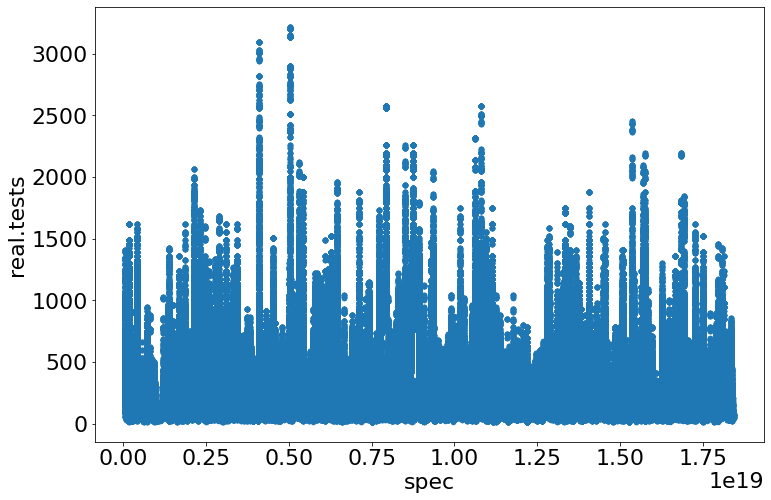

In [65]:
frame = real_max.compute()
frame.reset_index(inplace=True)
frame.plot.scatter(x="spec", y="real.tests", figsize=(12, 8))

### Relative scatter plot

In [66]:
relative_dist = real_max.compute().reset_index(level="variant").join(real_statistics.compute(), on="spec")
relative_dist

/tmp/ipykernel_35553/81309591.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  relative_dist = real_max.compute().reset_index(level="variant").join(real_statistics.compute(), on="spec")


,variant,real.tests,real.downs,size,clocks,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)","(clocks, max)","(clocks, mean)"
spec,,,,,,,,,,,,,,,,,
51892533938074794,0,63,27,4,4,56,132,92.75,26,48,36.250000,4,4,4.0,4,4,4.0
51892533938074794,1,87,33,4,4,56,132,92.75,26,48,36.250000,4,4,4.0,4,4,4.0
51892533938074794,2,63,27,4,4,56,132,92.75,26,48,36.250000,4,4,4.0,4,4,4.0
51892533938074794,3,87,33,4,4,56,132,92.75,26,48,36.250000,4,4,4.0,4,4,4.0
51892533938074794,4,87,33,4,4,56,132,92.75,26,48,36.250000,4,4,4.0,4,4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18432962492680829874,19,62,28,4,5,44,80,63.75,21,34,27.416667,4,4,4.0,5,5,5.0
18432962492680829874,20,76,32,4,5,44,80,63.75,21,34,27.416667,4,4,4.0,5,5,5.0
18432962492680829874,21,54,25,4,5,44,80,63.75,21,34,27.416667,4,4,4.0,5,5,5.0


In [67]:
def scale_reals(row):
    new_rows = dict()
    test_min = row[("real.tests", "min")]
    test_max = row[("real.tests", "max")]
    if test_max == test_min:
        new_rows["rel_tests"] = 0
    else:
        new_rows["rel_tests"] = (row["real.tests"] - test_min) / (test_max - test_min)
    down_min = row[("real.downs", "min")]
    down_max = row[("real.downs", "max")]
    if down_min == down_max:
        new_rows["rel_downs"] = 0
    else:
        new_rows["rel_downs"] = (row["real.downs"] - down_min) / (down_max - down_min)
    new_rows["size"] = row["size"]
    new_rows["clocks"] = row["clocks"]
    return new_rows
relative_dist = relative_dist.apply(scale_reals, axis=1, result_type='expand')
relative_dist

,rel_tests,rel_downs,size,clocks
spec,,,,
51892533938074794,0.092105,0.045455,4.0,4.0
51892533938074794,0.407895,0.318182,4.0,4.0
51892533938074794,0.092105,0.045455,4.0,4.0
51892533938074794,0.407895,0.318182,4.0,4.0
51892533938074794,0.407895,0.318182,4.0,4.0
...,...,...,...,...
18432962492680829874,0.500000,0.538462,4.0,5.0
18432962492680829874,0.888889,0.846154,4.0,5.0
18432962492680829874,0.277778,0.307692,4.0,5.0


In [68]:
relative_dist4 = relative_dist[relative_dist["size"] == 4]

<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

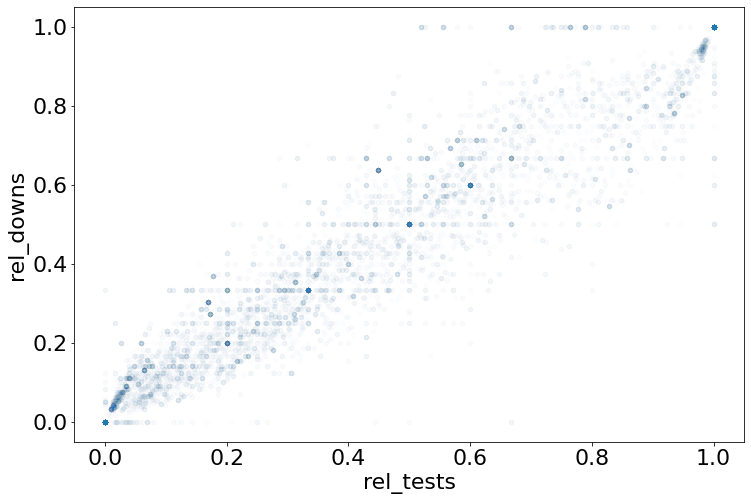

In [69]:
relative_dist4.plot.scatter(x="rel_tests", y="rel_downs", alpha=0.01, figsize=(12, 8))


<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

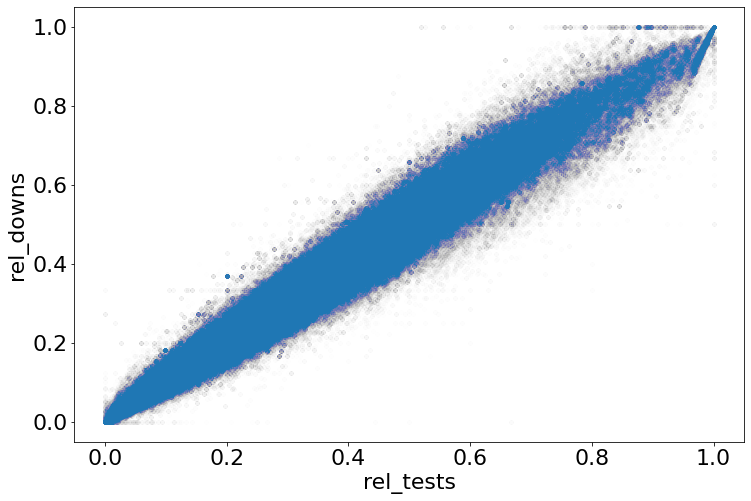

In [70]:
relative_dist.plot.scatter(x="rel_tests", y="rel_downs", alpha=0.005, figsize=(12, 8))


In [71]:
num_points = relative_dist.groupby("spec").aggregate(len).sort_values("rel_tests")

<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

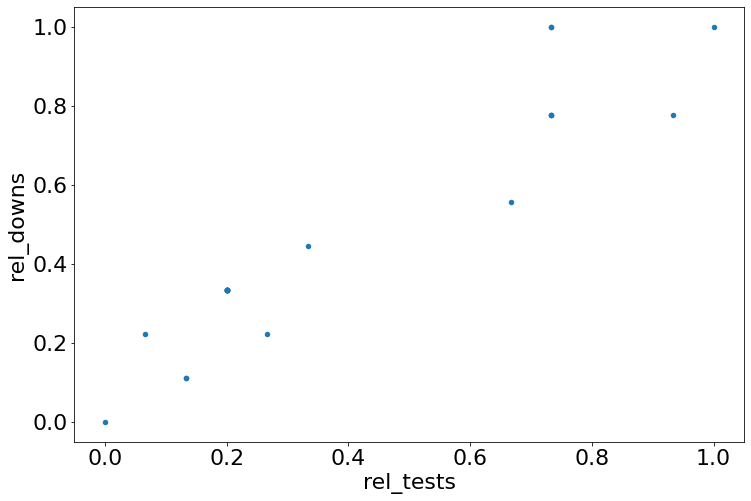

In [72]:
relative_dist.loc[num_points.index[2]].plot.scatter(x="rel_tests", y="rel_downs", figsize=(12, 8))


In [73]:
import os

all_methods_comp = real_statistics
methods = []
for file in os.listdir(dir+"/opti"):
     filename = os.fsdecode(file)
     if filename.endswith(".parquet"):
         table = dd.read_parquet(dir+"opti/"+filename, index=["spec"],columns=["real.tests"])
         table = table.groupby("spec").max()
         method = filename.replace(".parquet", "")
         table = table.rename(columns={"real.tests": method})
         methods.append(method)
         all_methods_comp = all_methods_comp.join(table)
     else:
         continue
all_methods_comp = all_methods_comp.compute()
all_methods_comp

/home/ptokarie/code/ccsl-rs/plotter/venv/lib/python3.9/site-packages/dask/dataframe/multi.py:393: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  meta = left._meta_nonempty.merge(right._meta_nonempty, **kwargs)
/home/ptokarie/code/ccsl-rs/plotter/venv/lib/python3.9/site-packages/dask/dataframe/multi.py:275: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  out = lhs.merge(rhs, *args, **kwargs)


,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)",...,random,sort_min_weights,init_weights.min_front,min_out.tree_width,tricost.dijkstra,min_out.dijkstra,init_weights.dijkstra,random.dijkstra,min_out.tree_depth,min_out.min_front
spec,,,,,,,,,,,,,,,,,,,,,
51892533938074794,56,132,92.750000,26,48,36.250000,4,4,4.0,4,...,116,84,56,56,56,56,56,56,88,56
57036280707606070,213,1412,566.778571,108,484,211.180952,7,7,7.0,8,...,273,277,213,232,222,223,222,395,214,214
58056975540577006,94,884,279.266667,36,272,95.514286,7,7,7.0,7,...,220,356,152,116,100,100,100,168,152,152
61760932481443283,51,116,82.166667,21,40,29.083333,4,4,4.0,5,...,88,70,51,51,51,51,51,88,51,51
71494259075619179,34,148,74.166667,16,60,31.833333,4,4,4.0,7,...,148,68,34,36,34,36,34,44,36,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18392748334620384884,69,124,88.166667,36,52,42.083333,4,4,4.0,5,...,69,80,69,76,69,76,69,75,76,76
18393744352728927060,20,52,32.583333,10,26,15.916667,4,4,4.0,5,...,32,51,20,23,20,23,20,20,23,23
18414416888391821950,52,82,63.500000,21,33,25.750000,4,4,4.0,4,...,52,52,52,52,52,52,52,61,57,52


In [74]:
def diffs(row):
    new_row = dict()
    mean = row[("real.tests", "mean")]
    for i,c in enumerate(methods, start=1):
        new_row[c] = int(row[c] < mean or row[("real.tests", "min")] == row[("real.tests", "max")])
    return new_row
diffs_comp = all_methods_comp.copy()
diffs_comp = diffs_comp.apply(diffs, axis=1, result_type='expand')
diffs_comp

,random.min_front,tricost.min_front,random,sort_min_weights,init_weights.min_front,min_out.tree_width,tricost.dijkstra,min_out.dijkstra,init_weights.dijkstra,random.dijkstra,min_out.tree_depth,min_out.min_front
spec,,,,,,,,,,,,
51892533938074794,1,1,0,1,1,1,1,1,1,1,1,1
57036280707606070,1,1,1,1,1,1,1,1,1,1,1,1
58056975540577006,1,1,1,0,1,1,1,1,1,1,1,1
61760932481443283,0,1,0,1,1,1,1,1,1,0,1,1
71494259075619179,1,1,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
18392748334620384884,1,1,1,1,1,1,1,1,1,1,1,1
18393744352728927060,1,1,1,0,1,1,1,1,1,1,1,1
18414416888391821950,1,1,1,1,1,1,1,1,1,1,1,1


### Percentage of good optimized specifications by method

In [75]:
diffs_comp.apply(sum, axis=0).sort_values(ascending=False)/len(diffs_comp)

init_weights.min_front    0.993976
tricost.min_front         0.993373
tricost.dijkstra          0.991566
init_weights.dijkstra     0.990361
min_out.min_front         0.987952
min_out.dijkstra          0.984940
min_out.tree_depth        0.978313
random.min_front          0.972892
min_out.tree_width        0.969277
random.dijkstra           0.946386
sort_min_weights          0.685542
random                    0.568675
dtype: float64

### Visualisation of optimization coverage

<AxesSubplot:xlabel='spec'>

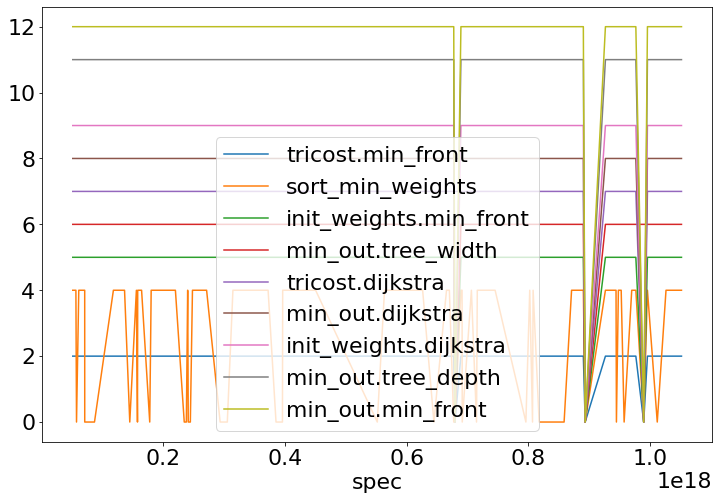

In [76]:
def scale_methods(row):
    new_row = dict()
    for i,c in enumerate(methods, start=1):
        if "random" in c:
            continue
        new_row[c] = i*row[c]
    return new_row
without_rand = diffs_comp.apply(scale_methods, axis=1, result_type='expand')
without_rand.iloc[:100].plot(figsize=(12, 8))

### Cumulative coverage

<AxesSubplot:xlabel='spec'>

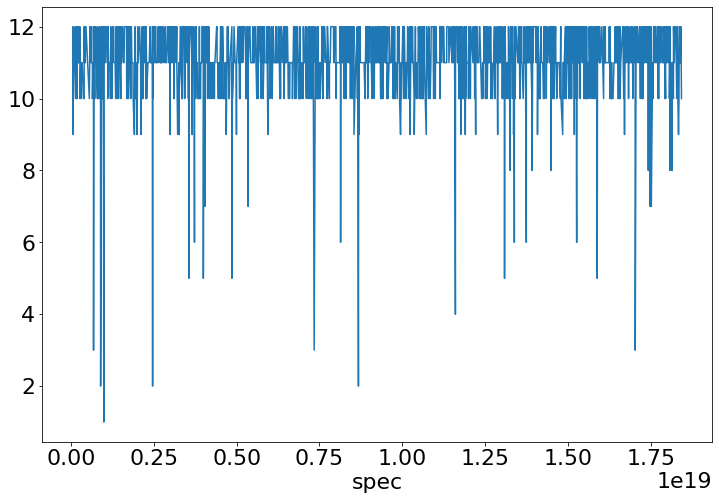

In [77]:
cumulative_comp = diffs_comp.apply(sum, axis=1)
cumulative_comp.plot(figsize=(12, 8))

### Uncovered specifications

In [78]:
cumulative_comp[cumulative_comp == 0]

Series([], dtype: int64)

In [79]:
starting = real_max.compute().reset_index(level="variant")
starting = starting[starting["variant"] == 0]
gain = starting.join(all_methods_comp)
gain = gain[(gain[("real.tests", "max")]/gain[("real.tests", "min")])>1.05]
gain

,variant,real.tests,real.downs,size,clocks,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)",...,random,sort_min_weights,init_weights.min_front,min_out.tree_width,tricost.dijkstra,min_out.dijkstra,init_weights.dijkstra,random.dijkstra,min_out.tree_depth,min_out.min_front
spec,,,,,,,,,,,,,,,,,,,,,
51892533938074794,0,63,27,4,4,56,132,92.750000,26,48,...,116,84,56,56,56,56,56,56,88,56
57036280707606070,0,597,225,7,8,213,1412,566.778571,108,484,...,273,277,213,232,222,223,222,395,214,214
58056975540577006,0,884,272,7,7,94,884,279.266667,36,272,...,220,356,152,116,100,100,100,168,152,152
61760932481443283,0,87,29,4,5,51,116,82.166667,21,40,...,88,70,51,51,51,51,51,88,51,51
71494259075619179,0,44,20,4,7,34,148,74.166667,16,60,...,148,68,34,36,34,36,34,44,36,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18392748334620384884,0,123,51,4,5,69,124,88.166667,36,52,...,69,80,69,76,69,76,69,75,76,76
18393744352728927060,0,51,25,4,5,20,52,32.583333,10,26,...,32,51,20,23,20,23,20,20,23,23
18414416888391821950,0,61,26,4,4,52,82,63.500000,21,33,...,52,52,52,52,52,52,52,61,57,52


### Gain in percentage relative to input specification

<AxesSubplot:ylabel='Frequency'>

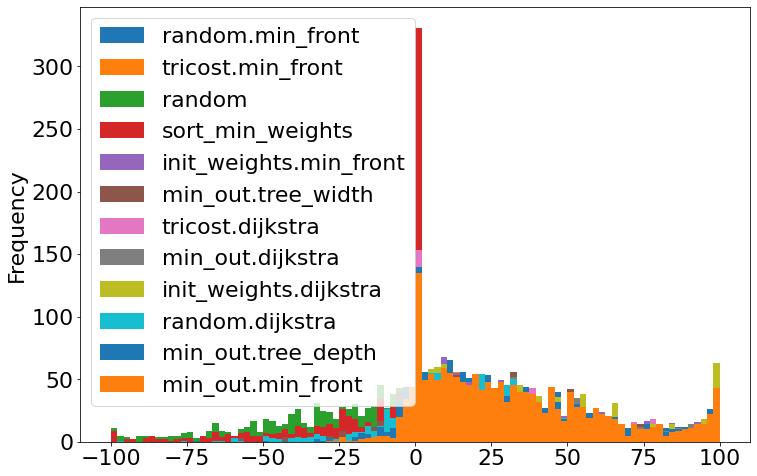

In [80]:
def gains_minus_start(row):
    new_row = dict()
    real = float(row["real.tests"])

    diff = (row[("real.tests", "max")] - row[("real.tests", "min")])
    for c in methods:
        new_row[c] = (real - float(row[c])) / diff * 100
    return new_row
gain_from_start = gain.apply(gains_minus_start, axis=1, result_type='expand')
gain_from_start.plot.hist(bins=96, alpha=1,figsize=(12, 8))

### Gain in percentage relative to input specification (specific method)

<AxesSubplot:ylabel='Frequency'>

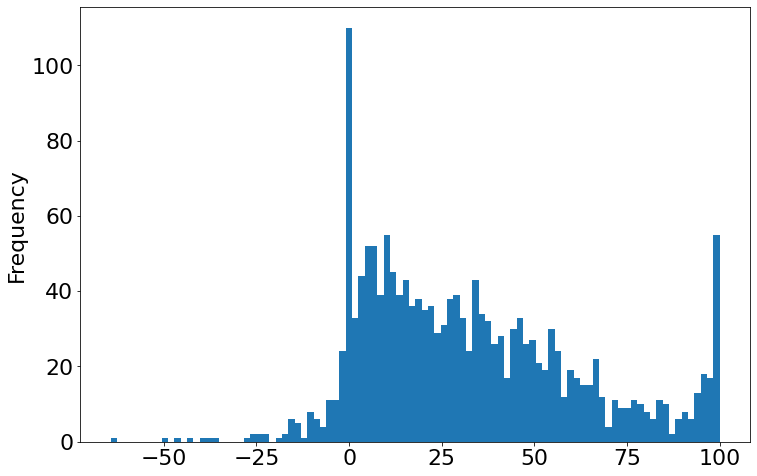

In [81]:
gain_from_start["init_weights.dijkstra"].plot.hist(bins=96, alpha=1,figsize=(12, 8))

### What are the 0 specs?

In [82]:
strange_0_specs = gain_from_start[["init_weights.min_front", ]][gain_from_start["init_weights.min_front"] == 0]
strange_0_specs = strange_0_specs.join(real_statistics.compute()).join(starting)
strange_0_specs

/tmp/ipykernel_35553/3746480298.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  strange_0_specs = strange_0_specs.join(real_statistics.compute()).join(starting)


,init_weights.min_front,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)","(clocks, max)","(clocks, mean)",variant,real.tests,real.downs,size,clocks
spec,,,,,,,,,,,,,,,,,,
118600122405516986,0.0,46,84,63.916667,24,36,31.083333,4,4,4.0,6,6,6.0,0,46,24,4,6
240609597492655580,0.0,42,54,45.750000,23,27,24.250000,4,4,4.0,5,5,5.0,0,42,23,4,5
271626161294329481,0.0,68,148,116.000000,32,52,44.000000,4,4,4.0,5,5,5.0,0,68,32,4,5
644826967107162380,0.0,75,132,95.750000,28,46,34.916667,4,4,4.0,5,5,5.0,0,75,28,4,5
679281214975076496,0.0,84,148,113.333333,36,52,43.333333,4,4,4.0,5,5,5.0,0,116,44,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17710486030002683782,0.0,116,212,142.666667,60,84,66.666667,4,4,4.0,6,6,6.0,0,116,60,4,6
18048592797143524581,0.0,42,116,69.500000,18,44,28.500000,4,4,4.0,6,6,6.0,0,60,24,4,6
18189404123434703775,0.0,49,212,107.983333,23,90,46.300000,5,5,5.0,6,6,6.0,0,77,30,5,6


<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

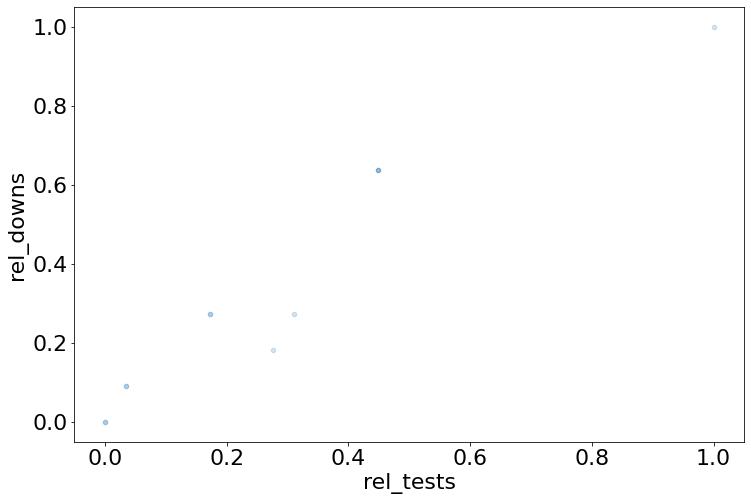

In [83]:
if len(strange_0_specs) != 0:
    relative_dist.loc[strange_0_specs.index[-1]].plot.scatter(x="rel_tests", y="rel_downs", alpha=0.1,figsize=(12, 8))

### Gain in percentage relative to mean

<AxesSubplot:ylabel='Frequency'>

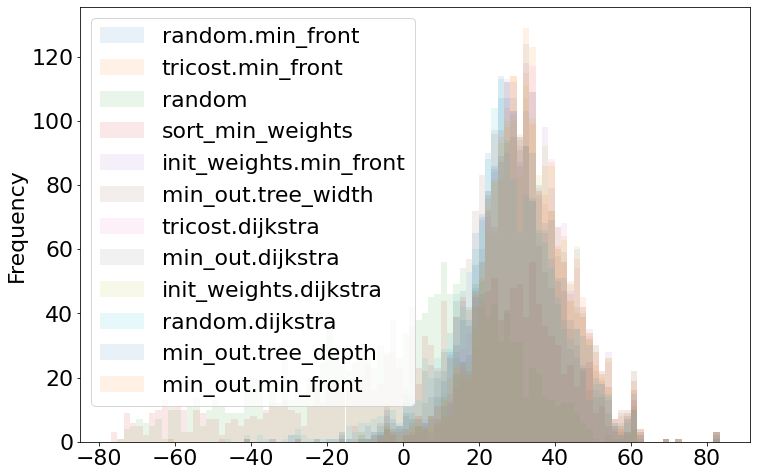

In [84]:
def gains_from_mean(row):
    new_row = dict()
    mean = float(row[("real.tests", "mean")])

    diff = (row[("real.tests", "max")] - row[("real.tests", "min")])
    for c in methods:
        new_row[c] = (mean - float(row[c])) / diff * 100
    return new_row
gain_from_mean = all_methods_comp.apply(gains_from_mean, axis=1, result_type='expand')
gain_from_mean.plot.hist(bins=96, alpha=0.1,figsize=(12, 8))

### Gain in percentage relative to mean

<AxesSubplot:ylabel='Frequency'>

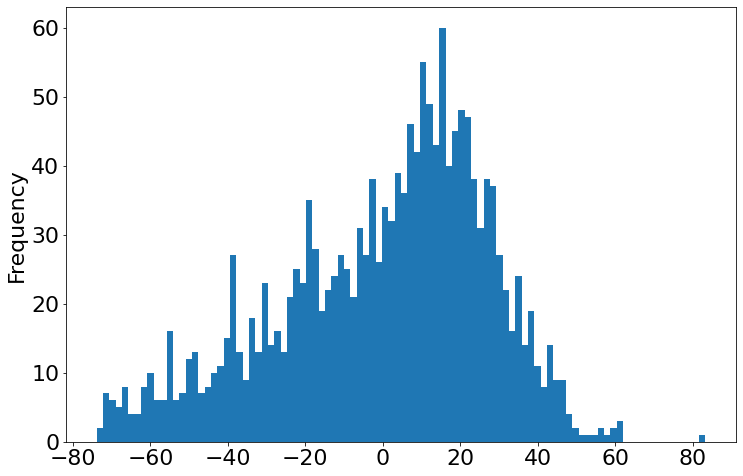

In [85]:
gain_from_mean["random"].plot.hist(bins=96, alpha=1,figsize=(12, 8))

<AxesSubplot:ylabel='Frequency'>

Text(0.5, 0, 'Improvement from mean (%)')

Text(0, 0.5, 'Frequency')

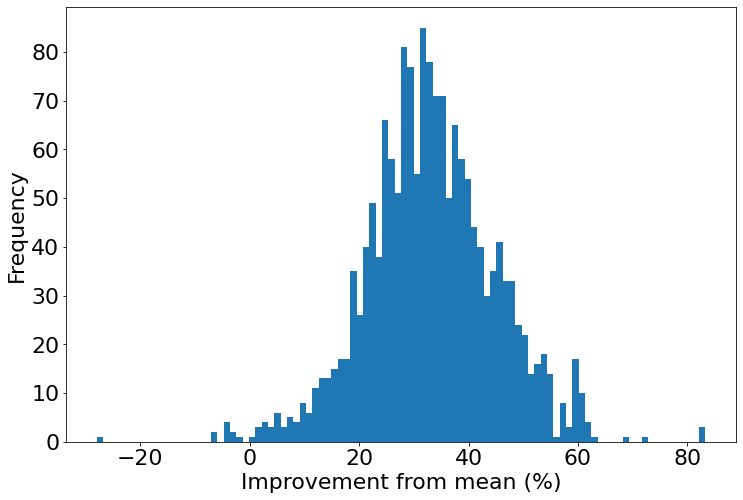

In [86]:
gain_from_mean["init_weights.min_front"].plot.hist(bins=96, alpha=1,figsize=(12, 8))
plt.xlabel("Improvement from mean (%)")
plt.ylabel("Frequency")
plt.savefig("optimization.pdf")

### Gain characteristics per method

In [134]:
gain_from_mean.aggregate(["mean", "std"], axis=0).transpose().sort_values("mean", ascending=False)

,mean,std
tricost.min_front,33.410890,11.503782
init_weights.min_front,33.190950,11.815970
tricost.dijkstra,33.080528,11.719377
init_weights.dijkstra,32.989682,12.040130
min_out.min_front,31.972976,12.191227
min_out.dijkstra,31.705292,12.277300
min_out.tree_depth,30.063495,12.634583
random.min_front,28.008291,13.258634
min_out.tree_width,27.324132,13.189184
random.dijkstra,26.115775,15.035156


### Complexity grow speed (by clocks)

In [135]:
real_max[["clocks", "real.tests"]].groupby("clocks").aggregate(["min", "max", "mean"]).compute().plot(figsize=(12, 8))

KeyboardInterrupt: 

### Complexity grow speed (by size)

In [ ]:
real_max[["size", "real.tests"]].groupby("size").aggregate(["min", "max", "mean"]).compute().plot(figsize=(12, 8))

In [ ]:
comparison_size_clock = comparison_squished.copy()
comparison_size_clock["approx.tests"] = comparison_size_clock["approx.tests"].astype(np.int64)
comparison_size_clock["diff_appr_real"] = ((comparison_size_clock["approx.tests"]-comparison_size_clock["real.tests"])/comparison_size_clock["real.tests"])
comparison_size_clock["diff_limit_real"] = ((comparison_size_clock["limit.tests"]-comparison_size_clock["real.tests"])/comparison_size_clock["real.tests"])
comparison_size_clock

In [ ]:
comparison_size_clock.groupby("size").aggregate("count")
comparison_size_clock.groupby("clocks").aggregate("count")


### Growth speed of difference of real and approximate complexities (by size)

In [ ]:
comparison_size_clock[["size", "diff_appr_real"]].groupby("size").agg(["max", "min", "mean"]).plot(figsize=(12,8))

In [ ]:
comparison_size_clock[["size", "diff_limit_real"]].groupby("size").agg(["max", "min", "mean"]).plot(figsize=(12,8))


### Growth speed of difference of real and approximate complexities (by clock)

In [ ]:
comparison_size_clock[["clocks", "diff_appr_real"]].groupby("clocks").agg(["max", "min", "mean"]).plot(figsize=(12,8))

In [ ]:
comparison_size_clock[["clocks", "diff_limit_real"]].groupby("clocks").agg(["max", "min", "mean"]).plot(figsize=(12,8))

### Check if approximations allow specification comparison

In [ ]:
check_order = comparison_squished[["real.tests", "approx.tests"]].reset_index(level="variant").drop("variant", axis=1).groupby("spec").aggregate(list)
check_order

In [ ]:
def order_holds(orig: List[int], aprox: List[int]) -> float:
    candidates = list(zip(orig, aprox))
    hold_times = 0
    count = 0
    for (lorig, laprox), (rorig, raprox) in combinations(candidates, 2):
        ok = (lorig < rorig and laprox < raprox) or \
          (lorig > rorig and laprox > raprox) or \
          (lorig == rorig and laprox == raprox)
        hold_times += int(ok)
        count +=1
    return hold_times/count

check_order["holds"] = check_order.apply(lambda row: order_holds(row["real.tests"], row["approx.tests"]), axis=1)
check_order.holds.mean()